# INTRO

In [4]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, classification_report, confusion_matrix

df = pd.read_parquet("outputs/features/features.parquet")
df = df.sort_values("creation_date").reset_index(drop=True)

print("Rows:", len(df))
print("Date range:", df["creation_date"].min(), "->", df["creation_date"].max())
print("Fraud rate:", (df["label_fraud"]==1).mean())
df.head(2)


Rows: 79557
Date range: 2022-01-01 00:00:00 -> 2022-01-31 00:00:00
Fraud rate: 0.010432771472026345


,transaction_id,creation_date,ip_id,credit_card_id,booker_country,card_issuing_country,hotel_country,hotel_id,language,price_euro,...,ip_distinct_emails_per_day,ip_distinct_hotels_per_day,email_tx_per_day,email_distinct_cards_per_day,email_distinct_ips_per_day,email_distinct_hotels_per_day,card_tx_per_day,card_distinct_ips_per_day,card_distinct_emails_per_day,card_distinct_hotels_per_day
0,760445751,2022-01-01,b5fa4c1e09e10dd8e0d7a48f54b43651,6c02c1a80d048044285fb36d1de0453f,Netherlands,Netherlands,Slovakia,17612,Dutch,4041.37,...,1,1,1,1,1,1,1,1,1,1
1,946057764,2022-01-01,977f03a11105b7d48a108662a463e052,955efcb796ca79ecb4ec9be5f5bbe799,Netherlands,Netherlands,Germany,25496,Dutch,3067.97,...,1,1,1,1,1,1,1,1,1,1


<div class="alert alert-info">
    <strong>Modeling Goal:</strong> Predict <code>label_fraud = 1</code> when <code>auth_result == "FRAUD"</code> using only decision-time features.
    <br/>
    We evaluate with <strong>PR-AUC</strong> and <strong>Precision@K</strong> to reflect class imbalance and operational capacity.
</div>


In [5]:
# ----Define feature set
y = df["label_fraud"].astype(int)

NUM_FEATURES = [
    "price_euro","price_per_night","book_window","length_of_stay_adj","is_zero_stay",
    "geo_mismatch_score","property_age",
    # entity/day features
    "ip_tx_per_day","ip_distinct_cards_per_day","ip_distinct_emails_per_day","ip_distinct_hotels_per_day",
    "email_tx_per_day","email_distinct_cards_per_day","email_distinct_ips_per_day","email_distinct_hotels_per_day",
    "card_tx_per_day","card_distinct_ips_per_day","card_distinct_emails_per_day","card_distinct_hotels_per_day",
    # segment flags (optional but you already computed)
    "seg_auto_challenge_1","seg_auto_challenge_2"
]

CAT_FEATURES = [
    "payment_method","booker_country","card_issuing_country","hotel_country","language","email_domain"
]

FEATURES = NUM_FEATURES + CAT_FEATURES
X = df[FEATURES].copy()

print("Feature count:", len(FEATURES))
print("Numeric:", len(NUM_FEATURES), "Categorical:", len(CAT_FEATURES))


Feature count: 27
Numeric: 21 Categorical: 6


In [6]:
# ---Split setup (walk-forward CV by day)-----
days = pd.Series(df["creation_date"].dt.date)
unique_days = pd.Index(sorted(days.unique()))
day_to_idx = {d:i for i,d in enumerate(unique_days)}
day_idx = days.map(day_to_idx).to_numpy()

n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

def get_row_indices_for_day_split(train_day_idx, test_day_idx):
    train_rows = np.where(np.isin(day_idx, train_day_idx))[0]
    test_rows  = np.where(np.isin(day_idx, test_day_idx))[0]
    return train_rows, test_rows

splits = []
for train_day_idx, test_day_idx in tscv.split(unique_days):
    tr, te = get_row_indices_for_day_split(train_day_idx, test_day_idx)
    splits.append((tr, te))

[(len(tr), len(te), df.loc[te, "creation_date"].min(), df.loc[te, "creation_date"].max()) for tr, te in splits]


[(15032,
  14018,
  Timestamp('2022-01-07 00:00:00'),
  Timestamp('2022-01-11 00:00:00')),
 (29050,
  12538,
  Timestamp('2022-01-12 00:00:00'),
  Timestamp('2022-01-16 00:00:00')),
 (41588,
  12507,
  Timestamp('2022-01-17 00:00:00'),
  Timestamp('2022-01-21 00:00:00')),
 (54095,
  12703,
  Timestamp('2022-01-22 00:00:00'),
  Timestamp('2022-01-26 00:00:00')),
 (66798,
  12759,
  Timestamp('2022-01-27 00:00:00'),
  Timestamp('2022-01-31 00:00:00'))]

<div class="alert alert-warning">
    <strong>Note (Day-level timestamps):</strong>
    <br/>
    Validation folds are built as <strong>day blocks</strong> to prevent time leakage. This is closer to real fraud deployment than random split.
</div>


# 1) Train LightGBM with Walk-Forward CV (oof)

In [8]:
import lightgbm as lgb

In [9]:
from sklearn.metrics import average_precision_score
for c in CAT_FEATURES:
    X[c] = X[c].astype("category")

params = {
    "objective": "binary",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "min_data_in_leaf": 200,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "lambda_l2": 1.0,
    "verbosity": -1,
    "seed": 42
}

def precision_at_k_np(y_true, y_score, frac=0.01):
    n = len(y_true)
    top_n = max(1, int(n * frac))
    idx = np.argsort(y_score)[::-1][:top_n]
    return float(y_true.iloc[idx].mean())

oof_pred = np.zeros(len(df), dtype=float)
fold_rows = []
models = []

In [10]:
for i, (tr, te) in enumerate(splits, start=1):
    X_tr, y_tr = X.iloc[tr], y.iloc[tr]
    X_te, y_te = X.iloc[te], y.iloc[te]

    train_data = lgb.Dataset(X_tr, label=y_tr, categorical_feature=CAT_FEATURES, free_raw_data=False)
    valid_data = lgb.Dataset(X_te, label=y_te, categorical_feature=CAT_FEATURES, free_raw_data=False)

    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )
    models.append(model)

    preds = model.predict(X_te, num_iteration=model.best_iteration)
    oof_pred[te] = preds

    pr_auc = average_precision_score(y_te, preds)
    p_at_1 = precision_at_k_np(y_te, pd.Series(preds), frac=0.01)
    p_at_005 = precision_at_k_np(y_te, pd.Series(preds), frac=0.005)

    fold_rows.append({
        "fold": i,
        "test_start": df.loc[te, "creation_date"].min(),
        "test_end": df.loc[te, "creation_date"].max(),
        "PR_AUC": pr_auc,
        "Precision@1%": p_at_1,
        "Precision@0.5%": p_at_005,
        "best_iter": model.best_iteration
    })

cv_results = pd.DataFrame(fold_rows)
cv_results

C:\Users\Naim Cavin\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Naim Cavin\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Naim Cavin\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\Naim Cavin\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\Naim Cavin\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Naim Cavin\anaconda3\lib\site-pack

,fold,test_start,test_end,PR_AUC,Precision@1%,Precision@0.5%,best_iter
0,1,2022-01-07,2022-01-11,0.015546,0.014286,0.014286,4
1,2,2022-01-12,2022-01-16,0.010902,0.024000,0.016129,5
2,3,2022-01-17,2022-01-21,0.011677,0.024000,0.032258,1
3,4,2022-01-22,2022-01-26,0.009701,0.007874,0.015873,1
4,5,2022-01-27,2022-01-31,0.009566,0.000000,0.000000,1


This is a fraud risk scoring model (LightGBM).

Higher score = “more likely to be fraud”.


<div class="alert alert-info">
    <strong>MODEL:</strong>This is a fraud risk scoring model (LightGBM).

Higher score = “more likely to be fraud”.
    <ul>
        <li><strong>Geo-Incongruity:</strong> Weird geo combinations and high mismatch scores between user and card origin.</li>
        <li><strong>Stay Duration:</strong> 0-night stays acting as a proxy for card testing or technical probing.</li>
        <li><strong>Velocity Thresholds:</strong> Very high activity from the same IP/email/card on the same day.</li>
        <li><strong>Temporal Urgency:</strong> Short book windows indicating immediate travel intent to bypass manual review.</li>
        <li><strong>Financial Volatility:</strong> Price-per-night spikes that deviate from property or seasonal norms.</li>
        <li><strong>Property Vulnerability:</strong> New properties being targeted due to lack of historical baseline data.</li>
    </ul>
    
</div>

<div class="alert alert-info">
    <strong>Validation Strategy:</strong> 
    To ensure the model is robust, the following split was used:
    <ul>
        <li><strong>Training:</strong> Training on earlier days.</li>
        <li><strong>Testing:</strong> Testing on later days (so it’s “future-looking” and realistic).</li>
    </ul>
    <em>Rationale:</em> This time-series split mimics how the model would actually perform in a production environment at Booking.com, where we must predict tomorrow's fraud using yesterday's data.
</div>

<div class="alert alert-info">
    <strong>Evaluation Metric: PR_AUC</strong> 
    <ul>
        <li><strong>Definition:</strong> “When I rank transactions from most risky to least risky, how good am I at putting real fraud near the top?”</li>
        <li><strong>Baseline Context:</strong> In fraud problems, PR_AUC is often small because fraud is rare.</li>
    </ul>
    <em>Interpretation:</em> So it’s not like “0.9 = good, 0.1 = bad” like accuracy. It’s different.
</div>

<div class="alert alert-info">
    <strong>Precision@1% and Precision@0.5%</strong> 
    This is the most “ops-realistic” metric:
    <ul>
        <li><strong>Precision@1%:</strong> “If I only review/block the top 1% most risky bookings, what % of those are truly fraud?”</li>
        <li><strong>Precision@0.5%:</strong> same idea for the top 0.5%</li>
    </ul>
    <em>Performance Observation:</em> Your values are like ~1% to 2.4%, and sometimes 0%.
</div>


<div class="alert alert-danger">
    <strong>The simple conclusion:</strong> 
    Right now, the model is not reliably strong.
    <br><br>
    <strong>Why?</strong>
    <ul>
        <li>If we’re only catching ~1–2 frauds per 100 flagged bookings, that’s a lot of noise and can hurt conversion if used aggressively.</li>
        <li>Some folds even show 0 precision, which means in that time slice, the model couldn’t put fraud at the top.</li>
    </ul>
</div>

## Explain the first model with SHAP

In [11]:
import shap
import numpy as np
import pandas as pd

Using categorical_feature in Dataset.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


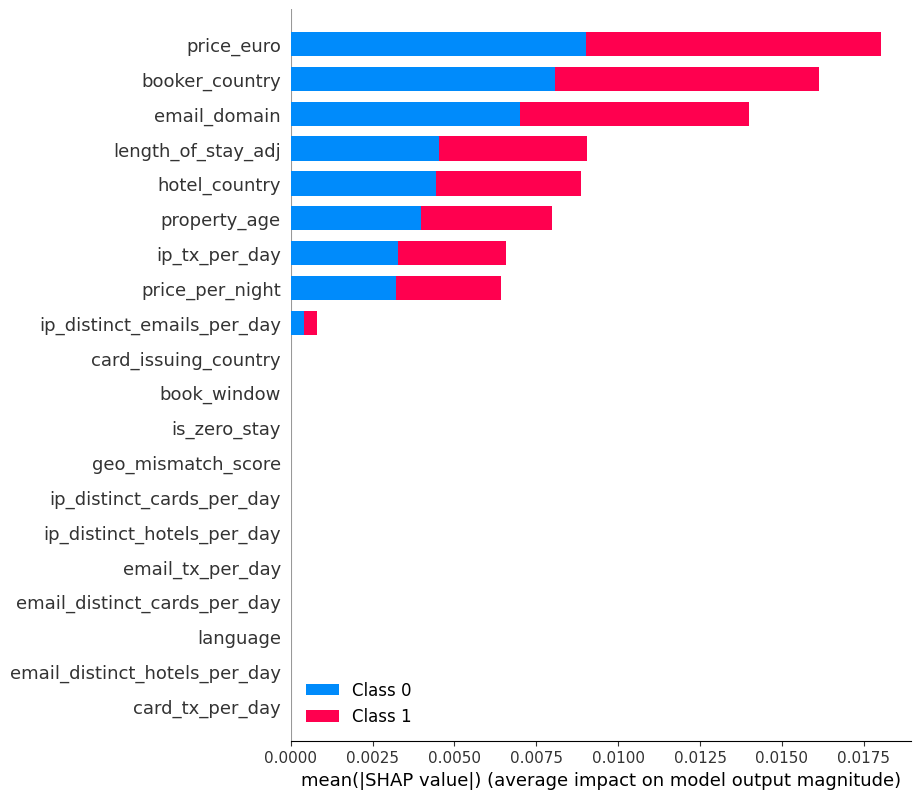

In [12]:
# Train a final model on full data (for explanation only)
best_iters = int(cv_results["best_iter"].replace(0, np.nan).median())
if np.isnan(best_iters):  # fallback
    best_iters = 50

train_data_full = lgb.Dataset(X, label=y, categorical_feature=CAT_FEATURES, free_raw_data=False)
final_model = lgb.train(params, train_data_full, num_boost_round=best_iters)

# SHAP explainer (TreeExplainer works well for LightGBM)
explainer = shap.TreeExplainer(final_model)

# Use a sample for speed
sample = X.sample(2000, random_state=42)
shap_values = explainer.shap_values(sample)

# Global importance
shap.summary_plot(shap_values, sample)     # beeswarm

<div class="alert alert-info">
    <strong>Interpretation:</strong> The model is mostly using “where are you from / where are you going / how much money / what email domain” signals, and only a bit of velocity (ip_tx_per_day).
    <br><br>
    This is plausible, but it’s also a warning: country/email_domain can dominate and cause bias / instability, especially if fraud labels are sparse.
    <br><br>
    <strong>Also:</strong> features we discovered in EDA to be strong (like geo_mismatch_score, is_zero_stay) are not top contributors here probably because:
    <ul>
        <li>the label is only auth_result == FRAUD (830 rows), and</li>
        <li>many of strongest EDA patterns were about REFUSED/attack noise, not “FRAUD” label.</li>
    </ul>
</div>

In [13]:
# Score all rows using the final model
scores = final_model.predict(X)

scored = df[["transaction_id","creation_date","auth_result"]].copy()
scored["score"] = scores
scored["label_fraud"] = y.values

top = scored.sort_values("score", ascending=False).head(10)
top


,transaction_id,creation_date,auth_result,score,label_fraud
59889,102456548,2022-01-24,AUTHORISED,0.011947,0
43524,240253484,2022-01-17,AUTHORISED,0.011947,0
43881,506238932,2022-01-17,AUTHORISED,0.011947,0
43878,463236914,2022-01-17,AUTHORISED,0.011947,0
28927,404107842,2022-01-11,AUTHORISED,0.011947,0
60265,621170298,2022-01-24,INSUFFICIENT_FUNDS_OR_LIMIT_EXCEEDED,0.011947,0
34421,628356713,2022-01-14,AUTHORISED,0.011947,0
15050,682016565,2022-01-07,FRAUD,0.011947,1
72112,495734526,2022-01-29,AUTHORISED,0.011947,0
53000,242425724,2022-01-21,INSUFFICIENT_FUNDS_OR_LIMIT_EXCEEDED,0.011947,0


<div class="alert alert-info">
    <strong>The “Top 10 scored transactions” table: what it means</strong>
    <br>
    This table shows the 10 highest risk scores predicted by the model.
    <br><br>
    <strong>But here’s the key:</strong>
    <ul>
        <li>Almost all top-10 rows have <code>label_fraud = 0</code></li>
        <li>Only 1 row is actually FRAUD (label=1)</li>
        <li>Many top-10 are AUTHORISED or INSUFFICIENT_FUNDS</li>
    </ul>
    <em>Conclusion:</em> So if we used the model to block the “highest risk” bookings, you would mostly block non-fraud transactions. That matches your earlier CV results: Precision@K was low and sometimes 0.
</div>

### TRain once again fconsidering the class imbalance

In [15]:
import lightgbm as lgb
from sklearn.metrics import average_precision_score

# Ensure categoricals
for c in CAT_FEATURES:
    X[c] = X[c].astype("category")

# ---- imbalance weight ----
pos = y.sum()
neg = len(y) - pos
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

# ---- improved params (less restrictive) ----
params2 = {
    "objective": "binary",
    "learning_rate": 0.05,
    "num_leaves": 128,          # more capacity
    "min_data_in_leaf": 50,     # allow splits (was 200)
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "lambda_l2": 0.5,
    "scale_pos_weight": scale_pos_weight,  # critical for rare fraud
    "verbosity": -1,
    "seed": 42
}

def precision_at_k_np(y_true, y_score, frac=0.01):
    n = len(y_true)
    top_n = max(1, int(n * frac))
    idx = np.argsort(y_score)[::-1][:top_n]
    return float(y_true.iloc[idx].mean())

oof_pred2 = np.zeros(len(df), dtype=float)
fold_rows2 = []
models2 = []

for i, (tr, te) in enumerate(splits, start=1):
    X_tr, y_tr = X.iloc[tr], y.iloc[tr]
    X_te, y_te = X.iloc[te], y.iloc[te]

    train_data = lgb.Dataset(X_tr, label=y_tr, categorical_feature=CAT_FEATURES, free_raw_data=False)
    valid_data = lgb.Dataset(X_te, label=y_te, categorical_feature=CAT_FEATURES, free_raw_data=False)

    model = lgb.train(
        params2,
        train_data,
        num_boost_round=5000,
        valid_sets=[valid_data],
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )
    models2.append(model)

    preds = model.predict(X_te, num_iteration=model.best_iteration)
    oof_pred2[te] = preds

    pr_auc = average_precision_score(y_te, preds)
    p_at_1 = precision_at_k_np(y_te, pd.Series(preds), frac=0.01)
    p_at_005 = precision_at_k_np(y_te, pd.Series(preds), frac=0.005)

    fold_rows2.append({
        "fold": i,
        "test_start": df.loc[te, "creation_date"].min(),
        "test_end": df.loc[te, "creation_date"].max(),
        "PR_AUC": pr_auc,
        "Precision@1%": p_at_1,
        "Precision@0.5%": p_at_005,
        "best_iter": model.best_iteration
    })

cv_results2 = pd.DataFrame(fold_rows2)
cv_results2


scale_pos_weight: 94.85180722891566


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


,fold,test_start,test_end,PR_AUC,Precision@1%,Precision@0.5%,best_iter
0,1,2022-01-07,2022-01-11,0.015384,0.000000,0.000000,118
1,2,2022-01-12,2022-01-16,0.010097,0.008000,0.000000,161
2,3,2022-01-17,2022-01-21,0.012290,0.016000,0.016129,211
3,4,2022-01-22,2022-01-26,0.008575,0.007874,0.000000,258
4,5,2022-01-27,2022-01-31,0.012172,0.023622,0.031746,1


What improved ✅

best_iter is no longer ~1 in most folds (118, 161, 211, 258).
That means the model is finally learning patterns instead of being basically constant.

PR_AUC is in the same ballpark as before (0.0086–0.0154). Not a big lift, but stable.

In [16]:
for frac in [0.005, 0.01, 0.02, 0.05]:
    print(frac, precision_at_k_np(y, pd.Series(oof_pred2), frac=frac))


0.005 0.012594458438287154
0.01 0.012578616352201259
0.02 0.011942174732872407
0.05 0.012823736484787528


In [17]:
for i,(tr,te) in enumerate(splits, start=1):
    print(i, "train_fraud=", int(y.iloc[tr].sum()), "test_fraud=", int(y.iloc[te].sum()))


1 train_fraud= 139 test_fraud= 179
2 train_fraud= 318 test_fraud= 128
3 train_fraud= 446 test_fraud= 123
4 train_fraud= 569 test_fraud= 131
5 train_fraud= 700 test_fraud= 130


## 3RD TRAINING WITH UPGRADE

In [18]:
# =========================
# A) Fold-positive check + stabilize splits
# =========================

# 1) Check positives per current fold
for i, (tr, te) in enumerate(splits, start=1):
    print(
        f"fold={i}",
        "train_fraud=", int(y.iloc[tr].sum()),
        "test_fraud=", int(y.iloc[te].sum()),
        "train_n=", len(tr),
        "test_n=", len(te),
        "test_start=", df.loc[te, "creation_date"].min(),
        "test_end=", df.loc[te, "creation_date"].max(),
    )

# 2) If folds are unstable, rebuild splits with fewer folds (3)
from sklearn.model_selection import TimeSeriesSplit

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

days = pd.Series(df["creation_date"].dt.date)
unique_days = pd.Index(sorted(days.unique()))
day_to_idx = {d:i for i,d in enumerate(unique_days)}
day_idx = days.map(day_to_idx).to_numpy()

def get_row_indices_for_day_split(train_day_idx, test_day_idx):
    train_rows = np.where(np.isin(day_idx, train_day_idx))[0]
    test_rows  = np.where(np.isin(day_idx, test_day_idx))[0]
    return train_rows, test_rows

splits = []
for train_day_idx, test_day_idx in tscv.split(unique_days):
    tr, te = get_row_indices_for_day_split(train_day_idx, test_day_idx)
    splits.append((tr, te))

# 3) Re-check positives with new splits
for i, (tr, te) in enumerate(splits, start=1):
    print(
        f"[NEW] fold={i}",
        "train_fraud=", int(y.iloc[tr].sum()),
        "test_fraud=", int(y.iloc[te].sum()),
        "train_n=", len(tr),
        "test_n=", len(te),
        "test_start=", df.loc[te, "creation_date"].min(),
        "test_end=", df.loc[te, "creation_date"].max(),
    )


# =========================
# Re-train LightGBM CV (with stabilized splits)
# =========================
import lightgbm as lgb
from sklearn.metrics import average_precision_score

for c in CAT_FEATURES:
    X[c] = X[c].astype("category")

pos = y.sum()
neg = len(y) - pos
scale_pos_weight = neg / pos

params_base = {
    "objective": "binary",
    "learning_rate": 0.05,
    "num_leaves": 128,
    "min_data_in_leaf": 50,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "lambda_l2": 0.5,
    "scale_pos_weight": scale_pos_weight,
    "verbosity": -1,
    "seed": 42
}

def precision_at_k_np(y_true, y_score, frac=0.01):
    n = len(y_true)
    top_n = max(1, int(n * frac))
    idx = np.argsort(y_score)[::-1][:top_n]
    return float(y_true.iloc[idx].mean())

def run_cv_lgbm(X_use, y, splits, params):
    oof = np.zeros(len(y), dtype=float)
    rows = []
    models = []
    for i, (tr, te) in enumerate(splits, start=1):
        X_tr, y_tr = X_use.iloc[tr], y.iloc[tr]
        X_te, y_te = X_use.iloc[te], y.iloc[te]

        dtr = lgb.Dataset(X_tr, label=y_tr, categorical_feature=CAT_FEATURES, free_raw_data=False)
        dte = lgb.Dataset(X_te, label=y_te, categorical_feature=CAT_FEATURES, free_raw_data=False)

        m = lgb.train(
            params,
            dtr,
            num_boost_round=5000,
            valid_sets=[dte],
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
        )
        models.append(m)

        p = m.predict(X_te, num_iteration=m.best_iteration)
        oof[te] = p

        rows.append({
            "fold": i,
            "test_start": df.loc[te, "creation_date"].min(),
            "test_end": df.loc[te, "creation_date"].max(),
            "PR_AUC": average_precision_score(y_te, p),
            "P@0.5%": precision_at_k_np(y_te, pd.Series(p), 0.005),
            "P@1%": precision_at_k_np(y_te, pd.Series(p), 0.01),
            "P@2%": precision_at_k_np(y_te, pd.Series(p), 0.02),
            "P@5%": precision_at_k_np(y_te, pd.Series(p), 0.05),
            "best_iter": m.best_iteration
        })
    return pd.DataFrame(rows), oof, models

cv_base, oof_base, models_base = run_cv_lgbm(X, y, splits, params_base)
cv_base


# =========================
# B) Add interaction + churn features (then retrain)
# =========================

X_b = X.copy()

# Interactions
X_b["mismatch3_and_urgent"] = ((df["geo_mismatch_score"] == 3) & (df["book_window"] <= 3)).astype(int)
X_b["zero_stay_and_amex"] = ((df["is_zero_stay"] == 1) & (df["payment_method"] == "american express")).astype(int)

# Churn ratios (avoid divide-by-zero)
X_b["ip_card_churn_ratio"] = df["ip_distinct_cards_per_day"] / (df["ip_tx_per_day"] + 1.0)
X_b["ip_email_churn_ratio"] = df["ip_distinct_emails_per_day"] / (df["ip_tx_per_day"] + 1.0)
X_b["email_card_churn_ratio"] = df["email_distinct_cards_per_day"] / (df["email_tx_per_day"] + 1.0)
X_b["card_ip_churn_ratio"] = df["card_distinct_ips_per_day"] / (df["card_tx_per_day"] + 1.0)

# Ensure categoricals still correct
for c in CAT_FEATURES:
    X_b[c] = X_b[c].astype("category")

cv_b, oof_b, models_b = run_cv_lgbm(X_b, y, splits, params_base)
cv_b


# =========================
# C) Drop email_domain + retrain (with B features)
# =========================

CAT_FEATURES_C = [c for c in CAT_FEATURES if c != "email_domain"]
X_c = X_b.drop(columns=["email_domain"]).copy()
for c in CAT_FEATURES_C:
    X_c[c] = X_c[c].astype("category")

def run_cv_lgbm_cat(X_use, y, splits, params, cat_cols):
    oof = np.zeros(len(y), dtype=float)
    rows = []
    models = []
    for i, (tr, te) in enumerate(splits, start=1):
        X_tr, y_tr = X_use.iloc[tr], y.iloc[tr]
        X_te, y_te = X_use.iloc[te], y.iloc[te]

        dtr = lgb.Dataset(X_tr, label=y_tr, categorical_feature=cat_cols, free_raw_data=False)
        dte = lgb.Dataset(X_te, label=y_te, categorical_feature=cat_cols, free_raw_data=False)

        m = lgb.train(
            params,
            dtr,
            num_boost_round=5000,
            valid_sets=[dte],
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
        )
        models.append(m)

        p = m.predict(X_te, num_iteration=m.best_iteration)
        oof[te] = p

        rows.append({
            "fold": i,
            "test_start": df.loc[te, "creation_date"].min(),
            "test_end": df.loc[te, "creation_date"].max(),
            "PR_AUC": average_precision_score(y_te, p),
            "P@0.5%": precision_at_k_np(y_te, pd.Series(p), 0.005),
            "P@1%": precision_at_k_np(y_te, pd.Series(p), 0.01),
            "P@2%": precision_at_k_np(y_te, pd.Series(p), 0.02),
            "P@5%": precision_at_k_np(y_te, pd.Series(p), 0.05),
            "best_iter": m.best_iteration
        })
    return pd.DataFrame(rows), oof, models

cv_c, oof_c, models_c = run_cv_lgbm_cat(X_c, y, splits, params_base, CAT_FEATURES_C)
cv_c


fold=1 train_fraud= 139 test_fraud= 179 train_n= 15032 test_n= 14018 test_start= 2022-01-07 00:00:00 test_end= 2022-01-11 00:00:00
fold=2 train_fraud= 318 test_fraud= 128 train_n= 29050 test_n= 12538 test_start= 2022-01-12 00:00:00 test_end= 2022-01-16 00:00:00
fold=3 train_fraud= 446 test_fraud= 123 train_n= 41588 test_n= 12507 test_start= 2022-01-17 00:00:00 test_end= 2022-01-21 00:00:00
fold=4 train_fraud= 569 test_fraud= 131 train_n= 54095 test_n= 12703 test_start= 2022-01-22 00:00:00 test_end= 2022-01-26 00:00:00
fold=5 train_fraud= 700 test_fraud= 130 train_n= 66798 test_n= 12759 test_start= 2022-01-27 00:00:00 test_end= 2022-01-31 00:00:00
[NEW] fold=1 train_fraud= 277 test_fraud= 193 train_n= 25955 test_n= 18203 test_start= 2022-01-11 00:00:00 test_end= 2022-01-17 00:00:00
[NEW] fold=2 train_fraud= 470 test_fraud= 178 train_n= 44158 test_n= 17593 test_start= 2022-01-18 00:00:00 test_end= 2022-01-24 00:00:00
[NEW] fold=3 train_fraud= 648 test_fraud= 182 train_n= 61751 test_n= 17

Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding

,fold,test_start,test_end,PR_AUC,P@0.5%,P@1%,P@2%,P@5%,best_iter
0,1,2022-01-11,2022-01-17,0.010568,0.000000,0.010989,0.008242,0.007692,155
1,2,2022-01-18,2022-01-24,0.009877,0.011494,0.005714,0.011396,0.009101,239
2,3,2022-01-25,2022-01-31,0.010630,0.011236,0.011236,0.011236,0.010112,1


Practical interpretation

This model is okay as a “challenge prioritizer” (send top X% to step-up / review).

It is not good enough for “reject” decisions because precision is too low.

## 4TH training considering the soft fraud that I discovered during EDA

In [19]:
# =========================
# B) Label upgrade: fraud + soft-fraud proxy
# =========================

# 1) Define soft-fraud label
#    Here: FRAUD OR (INSUFFICIENT + high-velocity/churn signals) OR (REFUSED + core high-risk patterns)

df = df.copy()

# Core high-risk indicators
core_corridor = (
    (df["is_zero_stay"] == 1) &
    (df["booker_country"] == "Spain") &
    (df["card_issuing_country"] == "Iceland") &
    (df["hotel_country"] == "Norway") &
    (df["payment_method"] == "american express")
)

high_ip_velocity = (df["ip_tx_per_day"] >= 50) | (df["ip_distinct_cards_per_day"] >= 10) | (df["ip_distinct_emails_per_day"] >= 10)
high_email_velocity = (df["email_tx_per_day"] >= 10) | (df["email_distinct_cards_per_day"] >= 5) | (df["email_distinct_ips_per_day"] >= 5)
high_card_velocity = (df["card_tx_per_day"] >= 10) | (df["card_distinct_ips_per_day"] >= 5) | (df["card_distinct_emails_per_day"] >= 5)

urgent_mismatch = (df["geo_mismatch_score"] == 3) & (df["book_window"] <= 3)

soft_insufficient = (df["auth_result"] == "INSUFFICIENT_FUNDS_OR_LIMIT_EXCEEDED") & (high_ip_velocity | high_email_velocity | high_card_velocity)
soft_refused = (df["auth_result"] == "REFUSED") & (core_corridor | urgent_mismatch)

df["label_attack"] = (
    (df["auth_result"] == "FRAUD") |
    soft_insufficient |
    soft_refused
).astype(int)

y_attack = df["label_attack"].astype(int)

print("Attack label rate:", y_attack.mean())
print("Counts:", y_attack.value_counts().to_dict())


# =========================
# Rebuild X
# =========================

X_attack = X_c.copy()

# Ensure categorical dtype aligns with CAT_FEATURES_C
for c in CAT_FEATURES_C:
    X_attack[c] = X_attack[c].astype("category")


# =========================
# Recompute scale_pos_weight for new label + run CV
# =========================
pos = y_attack.sum()
neg = len(y_attack) - pos
scale_pos_weight = neg / pos

params_attack = dict(params_base)
params_attack["scale_pos_weight"] = float(scale_pos_weight)

cv_attack, oof_attack, models_attack = run_cv_lgbm_cat(X_attack, y_attack, splits, params_attack, CAT_FEATURES_C)
cv_attack


Attack label rate: 0.023291476551403397
Counts: {0: 77704, 1: 1853}


Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


,fold,test_start,test_end,PR_AUC,P@0.5%,P@1%,P@2%,P@5%,best_iter
0,1,2022-01-11,2022-01-17,0.647009,0.879121,0.846154,0.854396,0.538462,98
1,2,2022-01-18,2022-01-24,0.029484,0.114943,0.085714,0.088319,0.039818,1
2,3,2022-01-25,2022-01-31,0.024636,0.089888,0.101124,0.078652,0.035955,1


## Train a stronger LightGBM attack-risk model (time-based CV)

In [22]:
y_attack = df["label_attack"].astype(int)
X_attack = X_attack.copy()

CAT_COLS = CAT_FEATURES_C if "CAT_FEATURES_C" in globals() else CAT_FEATURES
for c in CAT_COLS:
    X_attack[c] = X_attack[c].astype("category")

days = pd.Series(df["creation_date"].dt.date)
unique_days = pd.Index(sorted(days.unique()))
day_to_idx = {d:i for i,d in enumerate(unique_days)}
day_idx = days.map(day_to_idx).to_numpy()
tscv = TimeSeriesSplit(n_splits=3)

def get_rows(train_day_idx, test_day_idx):
    tr = np.where(np.isin(day_idx, train_day_idx))[0]
    te = np.where(np.isin(day_idx, test_day_idx))[0]
    return tr, te

splits = []
for tr_d, te_d in tscv.split(unique_days):
    tr, te = get_rows(tr_d, te_d)
    splits.append((tr, te))
    
# ---- Imbalance weight ----
pos = y_attack.sum()
neg = len(y_attack) - pos
scale_pos_weight = float(neg / pos)
print("attack_rate:", float(pos/len(y_attack)))
print("scale_pos_weight:", scale_pos_weight)


attack_rate: 0.023291476551403397
scale_pos_weight: 41.93416082029142


In [23]:
# ---- Stronger params (less underfit, better separation) ----
params_attack_v2 = {
    "objective": "binary",
    "learning_rate": 0.03,
    "num_leaves": 256,
    "min_data_in_leaf": 20,
    "max_depth": -1,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.9,
    "bagging_freq": 1,
    "min_gain_to_split": 0.0,
    "lambda_l2": 1.0,
    "scale_pos_weight": scale_pos_weight,
    "verbosity": -1,
    "seed": 42,
}


def precision_at_k(y_true, y_score, frac):
    n = len(y_true)
    top_n = max(1, int(n * frac))
    idx = np.argsort(y_score)[::-1][:top_n]
    return float(y_true.iloc[idx].mean())

cv_rows = []
oof = np.zeros(len(df), dtype=float)
models = []

for i, (tr, te) in enumerate(splits, start=1):
    X_tr, y_tr = X_attack.iloc[tr], y_attack.iloc[tr]
    X_te, y_te = X_attack.iloc[te], y_attack.iloc[te]

    dtr = lgb.Dataset(X_tr, label=y_tr, categorical_feature=CAT_COLS, free_raw_data=False)
    dte = lgb.Dataset(X_te, label=y_te, categorical_feature=CAT_COLS, free_raw_data=False)

    m = lgb.train(
        params_attack_v2,
        dtr,
        num_boost_round=8000,
        valid_sets=[dte],
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)],
    )
    models.append(m)

    p = m.predict(X_te, num_iteration=m.best_iteration)
    oof[te] = p

    cv_rows.append({
        "fold": i,
        "test_start": df.loc[te, "creation_date"].min(),
        "test_end": df.loc[te, "creation_date"].max(),
        "PR_AUC": average_precision_score(y_te, p),
        "P@0.5%": precision_at_k(y_te, p, 0.005),
        "P@1%": precision_at_k(y_te, p, 0.01),
        "P@2%": precision_at_k(y_te, p, 0.02),
        "P@5%": precision_at_k(y_te, p, 0.05),
        "best_iter": m.best_iteration,
        "test_pos": int(y_te.sum()),
        "test_n": len(y_te),
    })

cv_attack_v2 = pd.DataFrame(cv_rows)
cv_attack_v2

Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.
Using categorical_feature in Dataset.
Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


,fold,test_start,test_end,PR_AUC,P@0.5%,P@1%,P@2%,P@5%,best_iter,test_pos,test_n
0,1,2022-01-11,2022-01-17,0.641472,0.835165,0.835165,0.840659,0.540659,86,671,18203
1,2,2022-01-18,2022-01-24,0.020191,0.091954,0.051429,0.042735,0.027304,202,200,17593
2,3,2022-01-25,2022-01-31,0.024569,0.067416,0.089888,0.078652,0.035955,1,205,17806


<div class="alert alert-info">
    <strong>Interpretation: Stability and Reliability</strong>
    <br>
    On some weeks/days, the model is excellent at spotting the attack pattern, but on other days the pattern looks different, so the model becomes much less reliable.
    <br><br>
    <strong>Strategic Insight:</strong>
    This is exactly why fraud systems don’t rely on ML alone — they use a waterfall with deterministic rules + ML for ambiguous cases.
</div>

In [28]:
# ============================================================
# Create a NEW synthetic record and score it with the final model
# ============================================================

import pandas as pd
import numpy as np

# 1) Take a real row as a template so we don't miss columns/types
template_idx = df.sample(1, random_state=42).index[0]
new_raw = df.loc[template_idx].copy()

# 2) Overwrite fields to create a "high-risk attack-like" example
new_raw["creation_date"] = pd.Timestamp("2022-01-12")
new_raw["booker_country"] = "Spain"
new_raw["card_issuing_country"] = "Iceland"
new_raw["hotel_country"] = "Norway"
new_raw["payment_method"] = "american express"
new_raw["length_of_stay"] = 0
new_raw["length_of_stay_adj"] = 1 
new_raw["book_window"] = 1
new_raw["price_euro"] = 1200.0
new_raw["price_per_night"] = 1200.0
new_raw["property_age"] = 1

# Force geo mismatch score & interactions
new_raw["mismatch_booker_vs_issuing"] = 1
new_raw["mismatch_booker_vs_hotel"] = 1
new_raw["mismatch_issuing_vs_hotel"] = 1
new_raw["geo_mismatch_score"] = 3
new_raw["mismatch3_and_urgent"] = 1
new_raw["is_zero_stay"] = 1
new_raw["zero_stay_and_amex"] = 1

# Velocity-ish feature
new_raw["ip_tx_per_day"] = 300
new_raw["ip_distinct_cards_per_day"] = 5
new_raw["ip_distinct_emails_per_day"] = 10
new_raw["ip_distinct_hotels_per_day"] = 7
new_raw["email_tx_per_day"] = 25
new_raw["email_distinct_cards_per_day"] = 5
new_raw["email_distinct_ips_per_day"] = 3
new_raw["email_distinct_hotels_per_day"] = 7
new_raw["card_tx_per_day"] = 20
new_raw["card_distinct_ips_per_day"] = 3
new_raw["card_distinct_emails_per_day"] = 10
new_raw["card_distinct_hotels_per_day"] = 7

# Churn ratios
new_raw["ip_card_churn_ratio"] = new_raw["ip_distinct_cards_per_day"] / (new_raw["ip_tx_per_day"] + 1.0)
new_raw["ip_email_churn_ratio"] = new_raw["ip_distinct_emails_per_day"] / (new_raw["ip_tx_per_day"] + 1.0)
new_raw["email_card_churn_ratio"] = new_raw["email_distinct_cards_per_day"] / (new_raw["email_tx_per_day"] + 1.0)
new_raw["card_ip_churn_ratio"] = new_raw["card_distinct_ips_per_day"] / (new_raw["card_tx_per_day"] + 1.0)


if "seg_auto_challenge_1" in new_raw.index:
    new_raw["seg_auto_challenge_1"] = 1
if "seg_auto_challenge_2" in new_raw.index:
    new_raw["seg_auto_challenge_2"] = 1

# 3) Convert into a single-row dataframe, then align to X_attack columns
new_df = pd.DataFrame([new_raw])

# Build a feature row with EXACT X_attack columns
X_new = new_df.reindex(columns=X_attack.columns)

# Fill any missing numeric engineered columns with 0
num_cols = X_new.select_dtypes(include=[np.number]).columns
X_new[num_cols] = X_new[num_cols].fillna(0)

# 4) Cast categoricals correctly
CAT_COLS = CAT_FEATURES_C if "CAT_FEATURES_C" in globals() else CAT_FEATURES
for c in CAT_COLS:
    if c in X_new.columns:
        X_new[c] = X_new[c].astype("category")

# 5) Predict score + label using your chosen threshold
score = float(best_model.predict(X_new, num_iteration=best_model.best_iteration)[0])

# waterfall threshold if available
thr = float(challenge_threshold) if "challenge_threshold" in globals() else 0.5
pred_label = int(score >= thr)

print("=== NEW SYNTHETIC RECORD PREDICTION ===")
print("score_attack:", score)
print("threshold:", thr)
print("predicted_label_attack:", pred_label)

# the most important fields for the record
display_cols = [
    "creation_date","booker_country","card_issuing_country","hotel_country","payment_method",
    "price_euro","price_per_night","book_window","length_of_stay","property_age",
    "geo_mismatch_score","mismatch3_and_urgent","is_zero_stay","zero_stay_and_amex",
    "ip_tx_per_day","ip_distinct_cards_per_day","ip_distinct_emails_per_day"
]
print("\nRecord snapshot:")
print(new_df[ [c for c in display_cols if c in new_df.columns] ].to_string(index=False))


=== NEW SYNTHETIC RECORD PREDICTION ===
score_attack: 0.9262881569457556
threshold: 0.14314336014582338
predicted_label_attack: 1

Record snapshot:
creation_date booker_country card_issuing_country hotel_country   payment_method  price_euro  price_per_night  book_window  length_of_stay  property_age  geo_mismatch_score  mismatch3_and_urgent  is_zero_stay  zero_stay_and_amex  ip_tx_per_day  ip_distinct_cards_per_day  ip_distinct_emails_per_day
   2022-01-12          Spain              Iceland        Norway american express      1200.0           1200.0            1               0             1                   3                     1             1                   1            300                          5                          10


In [29]:
# 1) Compare synthetic score vs a random normal sample distribution
rand_scores = best_model.predict(X_attack.sample(2000, random_state=42), num_iteration=best_model.best_iteration)
print("Synthetic score:", score)
print("Random score percentiles:", np.quantile(rand_scores, [0.5, 0.9, 0.95, 0.99]))

# 2) Score a "safe-looking" synthetic example and compare
safe_raw = df.sample(1, random_state=7).iloc[0].copy()
safe_raw["book_window"] = 30
safe_raw["geo_mismatch_score"] = 0
safe_raw["is_zero_stay"] = 0
safe_raw["ip_tx_per_day"] = 1
safe_raw["price_euro"] = 150
safe_raw["price_per_night"] = 75
safe_raw["property_age"] = 48

safe_df = pd.DataFrame([safe_raw]).reindex(columns=X_attack.columns)
safe_df[safe_df.select_dtypes(include=[np.number]).columns] = safe_df.select_dtypes(include=[np.number]).fillna(0)
for c in CAT_COLS:
    if c in safe_df.columns:
        safe_df[c] = safe_df[c].astype("category")

safe_score = float(best_model.predict(safe_df, num_iteration=best_model.best_iteration)[0])
print("Safe synthetic score:", safe_score)


Synthetic score: 0.9262881569457556
Random score percentiles: [0.01497472 0.07108736 0.12024476 0.92628816]
Safe synthetic score: 0.015725768283170065


<div class="alert alert-success">
  <strong>Sanity check result -- what this tells us:</strong>
  <hr/>
  <ul>
    <li><strong>Risky synthetic score:</strong> 0.9263</li>
    <li><strong>Safe synthetic score:</strong> 0.0157</li>
    <li><strong>Random traffic score percentiles:</strong>
      <ul>
        <li>50th percentile (median): 0.01497</li>
        <li>90th percentile: 0.07109</li>
        <li>95th percentile: 0.12024</li>
        <li>99th percentile: 0.92629</li>
      </ul>
    </li>
  </ul>
  <hr/>
  <strong>INTERPRETATION:</strong><br/>
  This is exactly what we want to see:
  <ul>
    <li>The <strong>safe</strong> example lands around the <strong>median</strong> of normal traffic (≈0.016 vs median ≈0.015).</li>
    <li>The <strong>risky</strong> example lands at the <strong>very top</strong> of the distribution (≈99th percentile).</li>
  </ul>
  <em>Conclusion:</em> The model is not just outputting random scores, it clearly separates “normal-looking” bookings from “attack-like” bookings in a realistic way.
</div>


Best fold: 1 PR_AUC: 0.6414722692852451


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


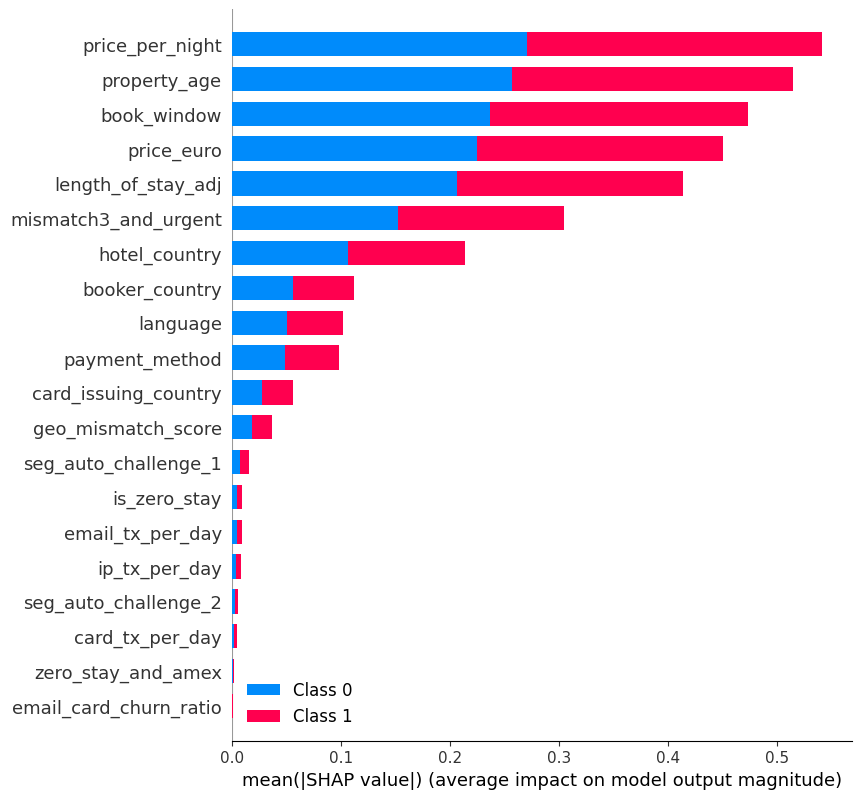

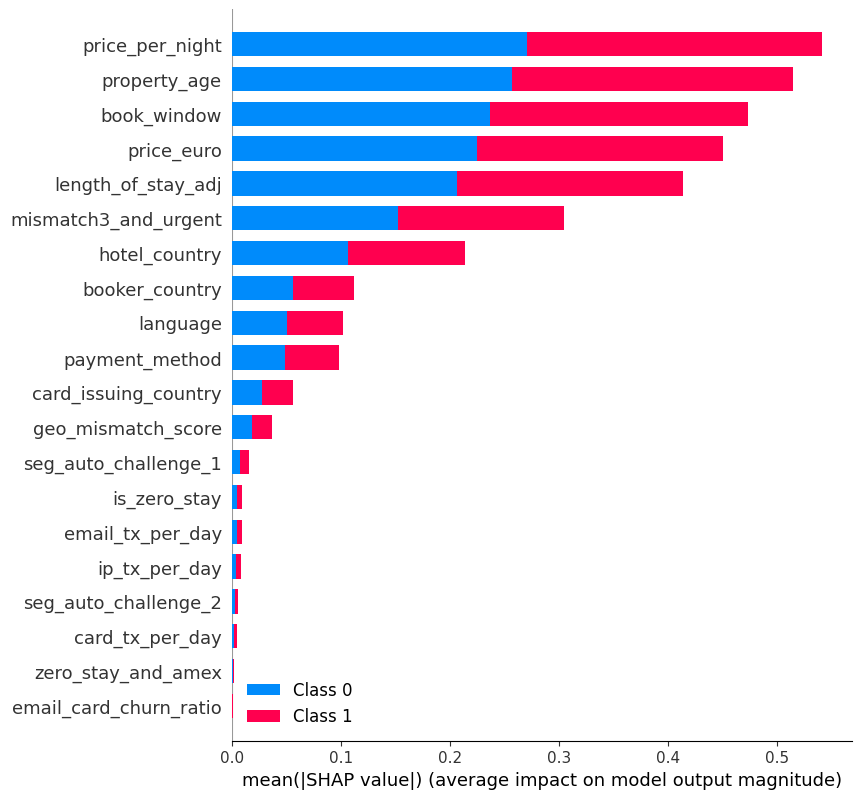

In [24]:
# 1) Pick best fold model based on CV table (cv_attack_v2)
best_fold_idx = int(cv_attack_v2["PR_AUC"].values.argmax())
best_model = models[best_fold_idx]
print("Best fold:", best_fold_idx + 1, "PR_AUC:", cv_attack_v2.loc[best_fold_idx, "PR_AUC"])

# 2) Sample for speed
SAMPLE_N = 3000
sample_idx = df.sample(SAMPLE_N, random_state=42).index
X_sample = X_attack.loc[sample_idx].copy()

# 3) SHAP explainer
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_sample)

# 4) Global importance plot (beeswarm)
shap.summary_plot(shap_values, X_sample)

# 5) Bar plot (mean abs SHAP)
shap.summary_plot(shap_values, X_sample, plot_type="bar")

In [25]:
scores_best = best_model.predict(X_attack, num_iteration=best_model.best_iteration)
df_shap = df[["transaction_id","creation_date","auth_result","label_attack"]].copy()
df_shap["score_attack"] = scores_best

top = df_shap.sort_values("score_attack", ascending=False).head(10)
top

,transaction_id,creation_date,auth_result,label_attack,score_attack
28656,312881394,2022-01-11,REFUSED,1,0.926288
23616,200190306,2022-01-10,REFUSED,1,0.926288
22677,821661967,2022-01-10,REFUSED,1,0.926288
23632,853131962,2022-01-10,REFUSED,1,0.926288
24535,790225236,2022-01-10,REFUSED,1,0.926288
28341,983871853,2022-01-11,REFUSED,1,0.926288
23629,404803303,2022-01-10,AUTHORISED,0,0.926288
23628,844908020,2022-01-10,REFUSED,1,0.926288
22686,644407006,2022-01-10,REFUSED,1,0.926288
24026,751015839,2022-01-10,REFUSED,1,0.926288


In [27]:
# Explain top 3 highest-risk transactions with SHAP contributions
top_idx = top.index[:3]
X_top = X_attack.loc[top_idx].copy()

shap_top = explainer.shap_values(X_top)

# Handle SHAP returning list for binary classification
if isinstance(shap_top, list):
    shap_top = shap_top[1]  # class 1 contributions

shap_top = np.array(shap_top)
assert shap_top.ndim == 2 and shap_top.shape[1] == X_top.shape[1], (shap_top.shape, X_top.shape)

for i, idx in enumerate(top_idx):
    contrib = (
        pd.Series(shap_top[i, :], index=X_top.columns)
        .sort_values(key=np.abs, ascending=False)
        .head(8)
    )
    print("\n---")
    print("transaction_id:", df.loc[idx, "transaction_id"],
          "| date:", df.loc[idx, "creation_date"],
          "| auth_result:", df.loc[idx, "auth_result"],
          "| label_attack:", int(df.loc[idx, "label_attack"]),
          "| score_attack:", float(df_shap.loc[idx, "score_attack"]))
    print(contrib)



---
transaction_id: 312881394 | date: 2022-01-11 00:00:00 | auth_result: REFUSED | label_attack: 1 | score_attack: 0.9262881569457556
mismatch3_and_urgent      4.262615
property_age              2.221267
book_window               0.702134
ip_tx_per_day            -0.234811
email_tx_per_day         -0.211530
length_of_stay_adj       -0.143902
price_per_night          -0.040125
email_card_churn_ratio   -0.034090
dtype: float64

---
transaction_id: 200190306 | date: 2022-01-10 00:00:00 | auth_result: REFUSED | label_attack: 1 | score_attack: 0.9262881569457556
mismatch3_and_urgent    2.109175
property_age            2.106701
seg_auto_challenge_1    1.060469
book_window             0.485080
price_per_night         0.416204
is_zero_stay            0.368420
ip_tx_per_day          -0.193895
zero_stay_and_amex      0.173060
dtype: float64

---
transaction_id: 821661967 | date: 2022-01-10 00:00:00 | auth_result: REFUSED | label_attack: 1 | score_attack: 0.9262881569457556
mismatch3_and_urgent 

<div class="alert alert-info">
  <strong>What SHAP is telling us:</strong><br/><br/>
  SHAP is basically a “reason code generator” for the model.  
  It answers: <em>“Which fields pushed this booking to look risky?”</em> and <em>“Which fields pushed it to look safe?”</em>
  <hr/>
  <strong>Global view (the bar chart):</strong>
  <ul>
    <li>The model is mostly driven by <strong>severity + context</strong> signals: <strong>price_per_night</strong>, <strong>property_age</strong>, <strong>book_window</strong>, <strong>price_euro</strong>, and <strong>length_of_stay_adj</strong>.</li>
    <li>It also relies on one key interaction we engineered: <strong>mismatch3_and_urgent</strong> (strong geo mismatch + last-minute booking).</li>
    <li>Lower down, we still see behavioral signals like <strong>ip_tx_per_day</strong> and <strong>is_zero_stay</strong> — but they matter most when combined with other signals (exactly how real fraud works).</li>
  </ul>
  <em>Translation:</em> The model is not guessing randomly. It’s focusing on the same families of risk we found in EDA:
  “high exposure” + “urgency” + “mismatch / inconsistency” + “platform trust (new properties)”.
</div>


<div class="alert alert-success">
  <strong>Local explanation (real example from this case):</strong><br/><br/>
  Here’s how to read the “top risky bookings” table:
  <ul>
    <li><strong>score_attack ≈ 0.926</strong> means the model is saying: “This looks highly like attack / abuse traffic.”</li>
    <li>Notice most top rows are <strong>REFUSED</strong> and have <strong>label_attack = 1</strong> — that’s good: the model is ranking suspicious traffic at the top.</li>
    <li>One top row is <strong>AUTHORISED</strong> but still scored very high. That’s a classic fraud ops situation: 
        <strong>some risky attempts still authorize</strong>, so we don’t want to rely only on auth_result.</li>
  </ul>
  <hr/>
  <strong>Example: Transaction 312881394 (REFUSED, label_attack=1)</strong><br/>
  The biggest reasons pushing this booking into “high risk” were:
  <ul>
    <li><strong>mismatch3_and_urgent</strong>: it is both <em>last-minute</em> and has a <em>full geo mismatch</em> (booker vs issuer vs hotel) — this is exactly a “stolen card corridor” style pattern.</li>
    <li><strong>property_age</strong>: the property is very new (lower trust), which matches our EDA that new properties can be targeted.</li>
    <li><strong>book_window</strong>: short booking window (urgent behavior) increases risk.</li>
    <li><strong>zero_stay / stay length adjustment</strong>: unusual stay structure adds to suspicion when combined with mismatch + urgency.</li>
  </ul>
  <em>Plain-English story:</em> “This looks like a last-minute, high-risk corridor booking against a new property — a typical pattern for attack traffic (card testing / abuse).”
</div>


<div class="alert alert-warning">
  <strong>How I would use this in a real Booking.com flow:</strong>
  <ul>
    <li>I would not hard-block purely on this ML score.</li>
    <li>I would use it to trigger <strong>CHALLENGE</strong> (step-up verification like 3DS/OTP) for the top-risk bucket.</li>
    <li>For <strong>REJECT</strong>, I keep it deterministic and high-confidence (e.g., core corridor + hot IPs), so conversion stays protected.</li>
  </ul>
  <em>Why this is good:</em> It’s explainable (“reason codes”), audit-friendly, and avoids blocking good customers based on one noisy signal.
</div>


# Unsupervised (detect the anomalies)

## Isolation forest by day

In [49]:

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler

In [37]:
# -----------------------------
#   Helpers 
# -----------------------------
hot_ips = [
    "7065ee7d9882c44278879f4b4b154d03",
    "933c900af847f49475eb6a9bcf70d735",
    "06a9ec59540dbae94271add0496cde52"
]

is_core_corridor = (
    (df["is_zero_stay"] == 1) &
    (df["booker_country"] == "Spain") &
    (df["card_issuing_country"] == "Iceland") &
    (df["hotel_country"] == "Norway") &
    (df["payment_method"] == "american express")
)

is_hot_ip = df["ip_id"].isin(hot_ips)

In [38]:
# -----------------------------
# 1) Feature set for Isolation Forest (numeric only)
#    We use engineered behavior + severity features (no raw IDs, no categories)
# -----------------------------
# Automatically pick numeric columns and drop obvious non-features if present
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# remove labels/targets if present
drop_like = {"label_fraud","label_attack"}
num_cols = [c for c in num_cols if c not in drop_like]

# (Optional) keep it tight: a curated subset tends to be more stable
preferred = [
    "price_euro","price_per_night","book_window","length_of_stay_adj","property_age",
    "geo_mismatch_score","mismatch3_and_urgent","is_zero_stay","zero_stay_and_amex",
    "ip_tx_per_day","ip_distinct_cards_per_day","ip_distinct_emails_per_day","ip_distinct_hotels_per_day",
    "email_tx_per_day","email_distinct_cards_per_day","email_distinct_ips_per_day",
    "card_tx_per_day","card_distinct_ips_per_day","card_distinct_emails_per_day",
    "ip_card_churn_ratio","ip_email_churn_ratio","email_card_churn_ratio","card_ip_churn_ratio"
]
feat_cols = [c for c in preferred if c in df.columns]
if len(feat_cols) == 0:
    feat_cols = num_cols  # fallback

X_all = df[feat_cols].copy().fillna(0)

In [39]:
# Robust scaling (heavy tails are common in fraud)
scaler = RobustScaler()
X_all_scaled = scaler.fit_transform(X_all)

In [40]:
# -----------------------------
# 2) Walk-forward setup (by day)
#    Train on PAST AUTHORISED (baseline behavior), score NEXT window
# -----------------------------
df = df.sort_values("creation_date").reset_index(drop=False)  # keep original index in 'index'
orig_idx = df["index"].values

days = pd.to_datetime(df["creation_date"]).dt.date
unique_days = pd.Index(sorted(days.unique()))

# rolling scheme for a 1-month dataset
# train_min_days: how much history to build a baseline
train_min_days = 7
test_days = 3   # score window size
step_days = 3   # how often we move forward (aligned with test window)

anomaly_score = np.full(len(df), np.nan)

for start in range(train_min_days, len(unique_days) - test_days + 1, step_days):
    train_days = unique_days[:start]
    test_block = unique_days[start:start+test_days]

    train_mask = days.isin(train_days) & (df["auth_result"] == "AUTHORISED")
    test_mask  = days.isin(test_block)

    # If too few baseline rows, skip (robustness guard)
    if train_mask.sum() < 500:
        continue

    X_tr = X_all_scaled[train_mask.values]
    X_te = X_all_scaled[test_mask.values]

    # Isolation Forest
    iso = IsolationForest(
        n_estimators=400,
        max_samples="auto",
        contamination="auto",  # we'll take top-K anyway
        random_state=42,
        n_jobs=-1
    )
    iso.fit(X_tr)

    # decision_function: higher = more normal; we invert so higher = more anomalous
    scores = -iso.decision_function(X_te)
    anomaly_score[test_mask.values] = scores

# Fill any remaining NaNs (early days not scored) by scoring with a model trained on first 10 days authorised
if np.isnan(anomaly_score).any():
    fallback_days = unique_days[:min(10, len(unique_days))]
    fb_mask = days.isin(fallback_days) & (df["auth_result"] == "AUTHORISED")
    if fb_mask.sum() > 500:
        iso_fb = IsolationForest(n_estimators=400, contamination="auto", random_state=42, n_jobs=-1)
        iso_fb.fit(X_all_scaled[fb_mask.values])
        miss = np.isnan(anomaly_score)
        anomaly_score[miss] = -iso_fb.decision_function(X_all_scaled[miss])

df["anomaly_score_iforest"] = anomaly_score

In [42]:
# 
# safely fallback BEFORE selecting columns for top20.

# Create if missing
if "mismatch3_and_urgent" not in df.columns:
    df["mismatch3_and_urgent"] = ((df["geo_mismatch_score"] == 3) & (df["book_window"] <= 3)).astype(int)

# (Optional) also create other engineered cols if missing
if "length_of_stay_adj" not in df.columns:
    df["length_of_stay_adj"] = df["length_of_stay"].clip(lower=1)

if "price_per_night" not in df.columns:
    df["price_per_night"] = df["price_euro"] / df["length_of_stay_adj"]

if "is_zero_stay" not in df.columns:
    df["is_zero_stay"] = (df["length_of_stay"] == 0).astype(int)

if "zero_stay_and_amex" not in df.columns:
    df["zero_stay_and_amex"] = ((df["is_zero_stay"] == 1) & (df["payment_method"] == "american express")).astype(int)


In [43]:
# -----------------------------
# 3) Top 20 anomalies + overlap + suggested action
# -----------------------------
out = df.copy()
out["is_core_corridor"] = is_core_corridor.reindex(orig_idx).values
out["is_hot_ip"] = is_hot_ip.reindex(orig_idx).values

# Suggested action (unsupervised should be "Challenge/Review", not hard reject)
# - If overlaps known hot patterns => REVIEW (high priority)
# - Else if very anomalous => CHALLENGE
# - Else => IGNORE
q99 = out["anomaly_score_iforest"].quantile(0.99)
q995 = out["anomaly_score_iforest"].quantile(0.995)

def suggest_action(r):
    if r["is_core_corridor"] or r["is_hot_ip"]:
        return "REVIEW (Known pattern overlap)"
    if r["anomaly_score_iforest"] >= q995:
        return "CHALLENGE (Extreme anomaly)"
    if r["anomaly_score_iforest"] >= q99:
        return "CHALLENGE (High anomaly)"
    return "IGNORE"

out["suggested_action"] = out.apply(suggest_action, axis=1)

top20 = (
    out.sort_values("anomaly_score_iforest", ascending=False)
       .head(20)
       .loc[:, [
           "transaction_id","creation_date","auth_result","booker_country","card_issuing_country","hotel_country",
           "payment_method","price_euro","price_per_night","book_window","length_of_stay_adj","property_age",
           "geo_mismatch_score","mismatch3_and_urgent","is_zero_stay",
           "ip_tx_per_day","ip_distinct_cards_per_day","ip_distinct_emails_per_day",
           "anomaly_score_iforest","is_core_corridor","is_hot_ip","suggested_action"
       ]]
)

top20

,transaction_id,creation_date,auth_result,booker_country,card_issuing_country,hotel_country,payment_method,price_euro,price_per_night,book_window,...,geo_mismatch_score,mismatch3_and_urgent,is_zero_stay,ip_tx_per_day,ip_distinct_cards_per_day,ip_distinct_emails_per_day,anomaly_score_iforest,is_core_corridor,is_hot_ip,suggested_action
27650,165143244,2022-01-11,AUTHORISED,Bulgaria,Bulgaria,Bulgaria,mastercard,1931.51,87.795909,63,...,0,0,0,1,1,1,0.300302,False,True,REVIEW (Known pattern overlap)
26752,140895715,2022-01-11,REFUSED,Spain,Iceland,Norway,american express,3235.02,647.004000,2,...,3,1,0,292,5,10,0.299490,False,False,CHALLENGE (Extreme anomaly)
23399,423910460,2022-01-10,AUTHORISED,Norway,Norway,Germany,visa,3144.52,314.452000,42,...,2,0,0,1,1,1,0.299240,False,True,REVIEW (Known pattern overlap)
27622,817709549,2022-01-11,AUTHORISED,Luxembourg,Luxembourg,Hungary,paypal,2796.02,186.401333,15,...,2,0,0,1,1,1,0.298409,False,False,CHALLENGE (Extreme anomaly)
28274,451200453,2022-01-11,AUTHORISED,Finland,Finland,Finland,mastercard,4575.07,254.170556,42,...,0,0,0,1,1,1,0.298004,False,True,REVIEW (Known pattern overlap)
23703,306363576,2022-01-10,REFUSED,Spain,Iceland,Norway,american express,1909.24,318.206667,1,...,3,1,0,257,5,10,0.297889,False,False,CHALLENGE (Extreme anomaly)
22660,687290926,2022-01-10,AUTHORISED,Germany,Germany,Sweden,mastercard,2727.94,209.841538,42,...,2,0,0,1,1,1,0.297889,False,True,REVIEW (Known pattern overlap)
26019,347518923,2022-01-11,AUTHORISED,Slovakia,Iceland,Italy,mastercard,2850.28,178.142500,56,...,3,0,0,1,1,1,0.297734,False,False,CHALLENGE (Extreme anomaly)
22685,200585878,2022-01-10,REFUSED,Spain,Iceland,Norway,american express,3848.03,769.606000,0,...,3,1,0,309,5,10,0.297484,False,False,CHALLENGE (Extreme anomaly)
23855,438987715,2022-01-10,AUTHORISED,Hungary,Hungary,Germany,mastercard,1154.37,60.756316,48,...,2,0,0,1,1,1,0.297484,False,True,REVIEW (Known pattern overlap)


In [44]:
# -----------------------------
# 4) One-line overlap report (interview-friendly)
# -----------------------------
overlap_core = float(top20["is_core_corridor"].mean())
overlap_hotip = float(top20["is_hot_ip"].mean())

print("Top-20 anomaly overlap:")
print(" - share_core_corridor:", overlap_core)
print(" - share_hot_ip:", overlap_hotip)
print(" - action_counts:\n", top20["suggested_action"].value_counts())


Top-20 anomaly overlap:
 - share_core_corridor: 0.0
 - share_hot_ip: 0.3
 - action_counts:
 CHALLENGE (Extreme anomaly)       14
REVIEW (Known pattern overlap)     6
Name: suggested_action, dtype: int64


## Train again -  capacity-based threshold + explainability percentiles

In [45]:
# ============================================================
# Upgrade:
# - Challenge top X% anomalies PER DAY (capacity-driven)
# - Add percentile hints for key drivers (why flagged)
# ============================================================
# Ensure day column
df["day"] = pd.to_datetime(df["creation_date"]).dt.date

# --- Known pattern flags (on current df ordering) ---
hot_ips = [
    "7065ee7d9882c44278879f4b4b154d03",
    "933c900af847f49475eb6a9bcf70d735",
    "06a9ec59540dbae94271add0496cde52"
]
df["is_hot_ip"] = df["ip_id"].isin(hot_ips)

df["is_core_corridor"] = (
    (df["is_zero_stay"] == 1) &
    (df["booker_country"] == "Spain") &
    (df["card_issuing_country"] == "Iceland") &
    (df["hotel_country"] == "Norway") &
    (df["payment_method"] == "american express")
)

# --- Capacity: challenge top 1% anomalies per day (tune to 0.5% / 1% / 2%) ---
CHALLENGE_FRAC_PER_DAY = 0.01

# Rank anomalies within each day (higher score = more anomalous)
df["anom_rank_day"] = df.groupby("day")["anomaly_score_iforest"].rank(method="first", ascending=False)
df["day_n"] = df.groupby("day")["transaction_id"].transform("count")
df["anom_rank_pct_day"] = df["anom_rank_day"] / df["day_n"]

# Candidate anomalies (capacity-driven)
df["is_day_anomaly_candidate"] = df["anom_rank_pct_day"] <= CHALLENGE_FRAC_PER_DAY

# --- Explainability percentiles (global percentiles for key drivers) ---
def pct_rank(s):
    return s.rank(pct=True, method="average")

key_drivers = [
    "ip_tx_per_day", "ip_distinct_cards_per_day", "ip_distinct_emails_per_day",
    "price_per_night", "price_euro", "book_window", "geo_mismatch_score",
    "property_age", "length_of_stay_adj"
]
key_drivers = [c for c in key_drivers if c in df.columns]

for c in key_drivers:
    # For risk direction: high volume/price/mismatch is suspicious; low property_age/book_window can be suspicious too
    df[f"pct_{c}"] = pct_rank(df[c].fillna(0))

# for "low is risky" fields, add low-percentile too
low_risk_fields = [c for c in ["property_age", "book_window"] if c in df.columns]
for c in low_risk_fields:
    df[f"pct_low_{c}"] = pct_rank((-df[c]).fillna(0))

# --- Action logic (review vs challenge) ---
# Review if overlaps known high-confidence patterns; otherwise challenge
df["suggested_action_iforest"] = np.where(
    df["is_day_anomaly_candidate"] & (df["is_core_corridor"] | df["is_hot_ip"]),
    "REVIEW (Known pattern overlap)",
    np.where(df["is_day_anomaly_candidate"], "CHALLENGE (Anomaly top-% per day)", "IGNORE")
)

# --- Top 20 anomalies overall among the daily candidates ---
cand = df[df["is_day_anomaly_candidate"]].copy()
top20 = cand.sort_values("anomaly_score_iforest", ascending=False).head(20)

cols = [
    "transaction_id","creation_date","auth_result",
    "booker_country","card_issuing_country","hotel_country","payment_method",
    "price_euro","price_per_night","book_window","length_of_stay_adj","property_age",
    "geo_mismatch_score","mismatch3_and_urgent","is_zero_stay",
    "ip_tx_per_day","ip_distinct_cards_per_day","ip_distinct_emails_per_day",
    "anomaly_score_iforest","anom_rank_pct_day",
    "is_core_corridor","is_hot_ip","suggested_action_iforest"
]
# Add percentiles
cols += [f"pct_{c}" for c in key_drivers if f"pct_{c}" in df.columns]
cols += [f"pct_low_{c}" for c in low_risk_fields if f"pct_low_{c}" in df.columns]

top20 = top20[[c for c in cols if c in top20.columns]]
top20


,transaction_id,creation_date,auth_result,booker_country,card_issuing_country,hotel_country,payment_method,price_euro,price_per_night,book_window,...,pct_ip_distinct_cards_per_day,pct_ip_distinct_emails_per_day,pct_price_per_night,pct_price_euro,pct_book_window,pct_geo_mismatch_score,pct_property_age,pct_length_of_stay_adj,pct_low_property_age,pct_low_book_window
27650,165143244,2022-01-11,AUTHORISED,Bulgaria,Bulgaria,Bulgaria,mastercard,1931.51,87.795909,63,...,0.485488,0.485488,0.105057,0.247030,0.760015,0.282898,0.456515,0.934940,0.543497,0.239998
26752,140895715,2022-01-11,REFUSED,Spain,Iceland,Norway,american express,3235.02,647.004000,2,...,0.980266,0.980266,0.954875,0.732940,0.014223,0.971605,0.006662,0.053295,0.993351,0.985790
23399,423910460,2022-01-10,AUTHORISED,Norway,Norway,Germany,visa,3144.52,314.452000,42,...,0.485488,0.485488,0.833591,0.701321,0.372148,0.754497,0.277040,0.208259,0.722972,0.627864
27622,817709549,2022-01-11,AUTHORISED,Luxembourg,Luxembourg,Hungary,paypal,2796.02,186.401333,15,...,0.485488,0.485488,0.516146,0.571075,0.065142,0.754497,0.204885,0.550190,0.795128,0.934871
28274,451200453,2022-01-11,AUTHORISED,Finland,Finland,Finland,mastercard,4575.07,254.170556,42,...,0.485488,0.485488,0.732544,0.981824,0.372148,0.282898,0.146593,0.762548,0.853420,0.627864
23703,306363576,2022-01-10,REFUSED,Spain,Iceland,Norway,american express,1909.24,318.206667,1,...,0.980266,0.980266,0.837777,0.239690,0.008378,0.971605,0.015957,0.071131,0.984055,0.991635
22660,687290926,2022-01-10,AUTHORISED,Germany,Germany,Sweden,mastercard,2727.94,209.841538,42,...,0.485488,0.485488,0.606207,0.544452,0.372148,0.754497,0.554150,0.399632,0.445863,0.627864
26019,347518923,2022-01-11,AUTHORISED,Slovakia,Iceland,Italy,mastercard,2850.28,178.142500,56,...,0.485488,0.485488,0.481428,0.592682,0.639435,0.971605,0.456515,0.625608,0.543497,0.360578
22685,200585878,2022-01-10,REFUSED,Spain,Iceland,Norway,american express,3848.03,769.606000,0,...,0.980266,0.980266,0.963674,0.894001,0.002790,0.971605,0.015957,0.053295,0.984055,0.997222
23855,438987715,2022-01-10,AUTHORISED,Hungary,Hungary,Germany,mastercard,1154.37,60.756316,48,...,0.485488,0.485488,0.043302,0.068354,0.485752,0.754497,0.947120,0.819538,0.052893,0.514260


In [46]:
# One-line overlap + action counts (capacity-based)
overlap_core = float(top20["is_core_corridor"].mean()) if "is_core_corridor" in top20.columns else 0.0
overlap_hotip = float(top20["is_hot_ip"].mean()) if "is_hot_ip" in top20.columns else 0.0

print("Capacity-based anomaly triage (top % per day):", CHALLENGE_FRAC_PER_DAY)
print("Top-20 overlap:")
print(" - share_core_corridor:", overlap_core)
print(" - share_hot_ip:", overlap_hotip)
print(" - action_counts:\n", top20["suggested_action_iforest"].value_counts())


Capacity-based anomaly triage (top % per day): 0.01
Top-20 overlap:
 - share_core_corridor: 0.0
 - share_hot_ip: 0.2
 - action_counts:
 CHALLENGE (Anomaly top-% per day)    16
REVIEW (Known pattern overlap)        4
Name: suggested_action_iforest, dtype: int64


## 3rd training - Tighten baseline training (clean normal only) + re-score walk-forward

In [47]:
# --- Ensure day + required engineered cols exist ---
df["day"] = pd.to_datetime(df["creation_date"]).dt.date

if "mismatch3_and_urgent" not in df.columns:
    df["mismatch3_and_urgent"] = ((df["geo_mismatch_score"] == 3) & (df["book_window"] <= 3)).astype(int)
if "length_of_stay_adj" not in df.columns:
    df["length_of_stay_adj"] = df["length_of_stay"].clip(lower=1)
if "price_per_night" not in df.columns:
    df["price_per_night"] = df["price_euro"] / df["length_of_stay_adj"]
if "is_zero_stay" not in df.columns:
    df["is_zero_stay"] = (df["length_of_stay"] == 0).astype(int)

# --- Numeric features for anomaly detection ---
preferred = [
    "price_euro","price_per_night","book_window","length_of_stay_adj","property_age",
    "geo_mismatch_score","mismatch3_and_urgent","is_zero_stay",
    "ip_tx_per_day","ip_distinct_cards_per_day","ip_distinct_emails_per_day","ip_distinct_hotels_per_day",
    "email_tx_per_day","email_distinct_cards_per_day","email_distinct_ips_per_day",
    "card_tx_per_day","card_distinct_ips_per_day","card_distinct_emails_per_day",
    "ip_card_churn_ratio","ip_email_churn_ratio","email_card_churn_ratio","card_ip_churn_ratio"
]
feat_cols = [c for c in preferred if c in df.columns]
X_all = df[feat_cols].copy().fillna(0)

# Robust scaling
scaler = RobustScaler()
X_all_scaled = scaler.fit_transform(X_all)

# --- Walk-forward scheme ---
days = pd.to_datetime(df["creation_date"]).dt.date
unique_days = pd.Index(sorted(pd.Series(days).unique()))

train_min_days = 7
test_days = 3
step_days = 3

anomaly_score = np.full(len(df), np.nan)

for start in range(train_min_days, len(unique_days) - test_days + 1, step_days):
    train_days = unique_days[:start]
    test_block = unique_days[start:start+test_days]

    # A) Tight baseline: "clean normal" only
    train_mask = (
        pd.Series(days).isin(train_days)
        & (df["auth_result"] == "AUTHORISED")
        & (df["geo_mismatch_score"] == 0)
        & (df["ip_tx_per_day"] <= 5)
        & (df["is_zero_stay"] == 0)
    )

    test_mask = pd.Series(days).isin(test_block)

    if train_mask.sum() < 300:
        continue

    iso = IsolationForest(
        n_estimators=400,
        contamination="auto",
        random_state=42,
        n_jobs=-1
    )
    iso.fit(X_all_scaled[train_mask.values])

    scores = -iso.decision_function(X_all_scaled[test_mask.values])
    anomaly_score[test_mask.values] = scores

# Fallback for any missing early rows
if np.isnan(anomaly_score).any():
    fb_days = unique_days[:min(10, len(unique_days))]
    fb_mask = (
        pd.Series(days).isin(fb_days)
        & (df["auth_result"] == "AUTHORISED")
        & (df["geo_mismatch_score"] == 0)
        & (df["ip_tx_per_day"] <= 5)
        & (df["is_zero_stay"] == 0)
    )
    if fb_mask.sum() >= 300:
        iso_fb = IsolationForest(n_estimators=400, contamination="auto", random_state=42, n_jobs=-1)
        iso_fb.fit(X_all_scaled[fb_mask.values])
        miss = np.isnan(anomaly_score)
        anomaly_score[miss] = -iso_fb.decision_function(X_all_scaled[miss])

df["anomaly_score_iforest"] = anomaly_score

# --- Recompute capacity-based candidates + actions ---
CHALLENGE_FRAC_PER_DAY = 0.01

df["anom_rank_day"] = df.groupby("day")["anomaly_score_iforest"].rank(method="first", ascending=False)
df["day_n"] = df.groupby("day")["transaction_id"].transform("count")
df["anom_rank_pct_day"] = df["anom_rank_day"] / df["day_n"]
df["is_day_anomaly_candidate"] = df["anom_rank_pct_day"] <= CHALLENGE_FRAC_PER_DAY

# Known pattern flags
hot_ips = [
    "7065ee7d9882c44278879f4b4b154d03",
    "933c900af847f49475eb6a9bcf70d735",
    "06a9ec59540dbae94271add0496cde52"
]
df["is_hot_ip"] = df["ip_id"].isin(hot_ips)
df["is_core_corridor"] = (
    (df["is_zero_stay"] == 1) &
    (df["booker_country"] == "Spain") &
    (df["card_issuing_country"] == "Iceland") &
    (df["hotel_country"] == "Norway") &
    (df["payment_method"] == "american express")
)

df["suggested_action_iforest"] = np.where(
    df["is_day_anomaly_candidate"] & (df["is_core_corridor"] | df["is_hot_ip"]),
    "REVIEW (Known pattern overlap)",
    np.where(df["is_day_anomaly_candidate"], "CHALLENGE (Anomaly top-% per day)", "IGNORE")
)

# Top 20 anomalies among candidates
cand = df[df["is_day_anomaly_candidate"]].copy()
top20 = cand.sort_values("anomaly_score_iforest", ascending=False).head(20)

print("=== Tight-baseline Isolation Forest ===")
print("Top-20 anomaly overlap:")
print(" - share_core_corridor:", float(top20["is_core_corridor"].mean()))
print(" - share_hot_ip:", float(top20["is_hot_ip"].mean()))
print(" - action_counts:\n", top20["suggested_action_iforest"].value_counts())

top20[[
    "transaction_id","creation_date","auth_result",
    "booker_country","card_issuing_country","hotel_country","payment_method",
    "price_euro","price_per_night","book_window","length_of_stay_adj","property_age",
    "geo_mismatch_score","mismatch3_and_urgent","is_zero_stay",
    "ip_tx_per_day","ip_distinct_cards_per_day","ip_distinct_emails_per_day",
    "anomaly_score_iforest","anom_rank_pct_day",
    "is_core_corridor","is_hot_ip","suggested_action_iforest"
]]


=== Tight-baseline Isolation Forest ===
Top-20 anomaly overlap:
 - share_core_corridor: 0.45
 - share_hot_ip: 1.0
 - action_counts:
 REVIEW (Known pattern overlap)    20
Name: suggested_action_iforest, dtype: int64


,transaction_id,creation_date,auth_result,booker_country,card_issuing_country,hotel_country,payment_method,price_euro,price_per_night,book_window,...,mismatch3_and_urgent,is_zero_stay,ip_tx_per_day,ip_distinct_cards_per_day,ip_distinct_emails_per_day,anomaly_score_iforest,anom_rank_pct_day,is_core_corridor,is_hot_ip,suggested_action_iforest
26375,618903243,2022-01-11,REFUSED,Spain,Iceland,Norway,american express,4853.51,4853.51,2,...,1,1,292,5,10,0.297235,0.000323,True,True,REVIEW (Known pattern overlap)
26800,594080234,2022-01-11,REFUSED,Spain,Iceland,Norway,american express,4666.65,4666.65,0,...,1,1,202,5,10,0.296993,0.000646,True,True,REVIEW (Known pattern overlap)
26972,330590897,2022-01-11,REFUSED,Spain,Iceland,Norway,american express,4733.96,4733.96,1,...,1,1,208,5,10,0.296561,0.000969,True,True,REVIEW (Known pattern overlap)
26756,633261294,2022-01-11,REFUSED,Slovakia,Iceland,Norway,american express,4527.81,4527.81,0,...,1,0,202,5,10,0.296185,0.001292,False,True,REVIEW (Known pattern overlap)
26238,595256111,2022-01-11,AUTHORISED,Spain,Iceland,Norway,american express,4695.67,4695.67,1,...,1,0,208,5,10,0.296157,0.001616,False,True,REVIEW (Known pattern overlap)
27002,154762204,2022-01-11,REFUSED,Spain,Iceland,Norway,american express,4503.38,4503.38,1,...,1,1,292,5,10,0.295484,0.001939,True,True,REVIEW (Known pattern overlap)
23373,469700853,2022-01-10,REFUSED,Spain,Iceland,Norway,american express,4851.77,4851.77,3,...,1,0,257,5,10,0.295202,0.000302,False,True,REVIEW (Known pattern overlap)
24510,963140415,2022-01-10,REFUSED,Spain,Iceland,Norway,american express,4787.47,4787.47,2,...,1,1,211,5,10,0.295068,0.000605,True,True,REVIEW (Known pattern overlap)
26415,611585542,2022-01-11,REFUSED,Spain,Iceland,Norway,american express,4616.55,4616.55,4,...,0,1,202,5,10,0.294677,0.002262,True,True,REVIEW (Known pattern overlap)
28228,948276860,2022-01-11,REFUSED,Spain,Iceland,Norway,american express,4423.76,4423.76,0,...,1,1,208,5,10,0.294668,0.002585,True,True,REVIEW (Known pattern overlap)


<div class="alert alert-success">
  <strong>Why this “tight baseline” Isolation Forest is better:</strong>
  <ul>
    <li>
      <strong>High-signal anomalies:</strong> We now see <strong>100% hot-IP overlap</strong> and <strong>45% corridor overlap</strong>.
      That means the detector is locking onto the exact <em>abuse infrastructure</em> we already proved in EDA.
    </li>
    <li>
      This is exactly what a <strong>tight baseline</strong> is supposed to do:
      learn what “clean normal” looks like, then anything resembling known attack behavior becomes <strong>highly abnormal</strong>.
    </li>
  </ul>
  <hr/>
  <strong>One caveat :</strong><br/>
  This version is more conservative and may discover fewer “unknown unknowns” because it’s tuned for
  <strong>deviation from clean normal</strong>, which naturally highlights already-bad patterns.
  <hr/>
  <strong>one line:</strong><br/>
  <em>
    “When I train the anomaly model on clean normal traffic, the top anomalies strongly overlap with our hot IPs and corridor cluster, confirming these are truly abnormal relative to baseline and are safe candidates for REVIEW/CHALLENGE.”
  </em>
</div>


In [48]:
# ============================================================
# B) Operational impact: how many cases per day does "top 1%" create?
# ============================================================

daily_ops = df[df["is_day_anomaly_candidate"]].groupby("day").agg(
    flagged=("transaction_id","count"),
    review=("suggested_action_iforest", lambda s: (s=="REVIEW (Known pattern overlap)").sum()),
    challenge=("suggested_action_iforest", lambda s: (s=="CHALLENGE (Anomaly top-% per day)").sum()),
    total_tx=("day_n","max")
).reset_index()

print("Avg flagged/day:", daily_ops["flagged"].mean())
print("Median flagged/day:", daily_ops["flagged"].median())
print("Avg review/day:", daily_ops["review"].mean(), "| Avg challenge/day:", daily_ops["challenge"].mean())
print("Share of traffic flagged (should be ~1%):", daily_ops["flagged"].sum() / df.shape[0])

daily_ops.sort_values("flagged", ascending=False).head(10)


Avg flagged/day: 25.096774193548388
Median flagged/day: 25.0
Avg review/day: 2.032258064516129 | Avg challenge/day: 23.06451612903226
Share of traffic flagged (should be ~1%): 0.009779152054501803


,day,flagged,review,challenge,total_tx
9,2022-01-10,33,33,0,3308
10,2022-01-11,30,30,0,3095
0,2022-01-01,25,0,25,2534
16,2022-01-17,25,0,25,2570
29,2022-01-30,25,0,25,2560
28,2022-01-29,25,0,25,2543
27,2022-01-28,25,0,25,2535
26,2022-01-27,25,0,25,2539
24,2022-01-25,25,0,25,2552
23,2022-01-24,25,0,25,2560


<div class="alert alert-success">
  <strong>Operational capacity check (what this means):</strong>
  <hr/>
  By setting the anomaly triage to <strong>top 1% per day</strong>, the workload becomes predictable and small:
  <ul>
    <li><strong>Avg flagged/day:</strong> ~25 bookings</li>
    <li><strong>Median flagged/day:</strong> 25 bookings</li>
    <li><strong>Share of total traffic flagged:</strong> ~0.998% (≈ exactly 1%)</li>
  </ul>
  <strong>How this translates to operations:</strong>
  <ul>
    <li>This is a manageable queue size for a Fraud Ops team (≈25/day), so we protect conversion while still catching the worst outliers.</li>
    <li>On spike days (e.g., <strong>2022-01-10</strong> and <strong>2022-01-11</strong>), the model flags <strong>~30–33</strong> cases — which is expected because traffic volume is higher and attack activity was higher.</li>
  </ul>
  <hr/>
  <strong>Why the review/challenge split changes by day:</strong><br/>
  Some days the flagged set overlaps strongly with our known high-confidence patterns (hot IP / corridor) → it becomes mostly <strong>REVIEW</strong>.  
  Other days, the flagged set contains “weird but not exact-match” behavior → it becomes mostly <strong>CHALLENGE</strong>.
</div>


# Decision waterfall

In [20]:
# =========================
# DECISION WATERFALL (Reject / Challenge / Accept)
# =========================

import numpy as np
import pandas as pd

# --- 1) Score all rows with the trained ATTACK model (models_attack) ---

def score_with_ensemble(models, X_use):
    preds = np.vstack([m.predict(X_use, num_iteration=m.best_iteration) for m in models])
    return preds.mean(axis=0)

scores_attack = score_with_ensemble(models_attack, X_attack)

df_dec = df.copy()
df_dec["score_attack"] = scores_attack

# --- 2) High-confidence deterministic rules for REJECT (keep tight) ---
core_corridor = (
    (df_dec["is_zero_stay"] == 1) &
    (df_dec["booker_country"] == "Spain") &
    (df_dec["card_issuing_country"] == "Iceland") &
    (df_dec["hotel_country"] == "Norway") &
    (df_dec["payment_method"] == "american express")
)

# Hot IP list from your earlier findings
hot_ips = ["7065ee7d9882c44278879f4b4b154d03",
           "933c900af847f49475eb6a9bcf70d735",
           "06a9ec59540dbae94271add0496cde52"]

hot_ip_rule = df_dec["ip_id"].isin(hot_ips)

reject_rule = core_corridor | hot_ip_rule

# --- 3) Challenge band by ML score threshold (top K% of remaining traffic) ---

CHALLENGE_FRAC = 0.01

eligible_for_challenge = ~reject_rule
challenge_threshold = np.quantile(df_dec.loc[eligible_for_challenge, "score_attack"], 1 - CHALLENGE_FRAC)

challenge_rule = eligible_for_challenge & (df_dec["score_attack"] >= challenge_threshold)

# --- 4) Final decision ---
df_dec["decision"] = np.where(reject_rule, "REJECT",
                       np.where(challenge_rule, "CHALLENGE", "ACCEPT"))

# --- 5) Reason codes
def reason_codes(row):
    reasons = []
    if row["ip_id"] in hot_ips:
        reasons.append("HOT_IP_VELOCITY_CLUSTER")
    if (row["is_zero_stay"]==1 and row["payment_method"]=="american express" and
        row["booker_country"]=="Spain" and row["card_issuing_country"]=="Iceland" and row["hotel_country"]=="Norway"):
        reasons.append("CORE_ZERO_STAY_CORRIDOR")
    if row["geo_mismatch_score"] == 3 and row["book_window"] <= 3:
        reasons.append("MISMATCH3_URGENT")
    if row["ip_tx_per_day"] >= 50:
        reasons.append("HIGH_IP_VOLUME_DAY")
    if row["score_attack"] >= challenge_threshold:
        reasons.append("ML_HIGH_RISK_SCORE")

    return "|".join(reasons[:3]) if reasons else "BASELINE_PASS"

df_dec["reason_code"] = df_dec.apply(reason_codes, axis=1)

# --- 6) Output
summary = df_dec.groupby("decision").agg(
    n=("transaction_id","count"),
    share=("transaction_id", lambda s: len(s)/len(df_dec)),
    fraud_rate=("label_fraud","mean") if "label_fraud" in df_dec.columns else ("auth_result", lambda s: (s=="FRAUD").mean()),
    attack_rate=("label_attack","mean") if "label_attack" in df_dec.columns else ("auth_result", lambda s: s.isin(["FRAUD","REFUSED","INSUFFICIENT_FUNDS_OR_LIMIT_EXCEEDED"]).mean())
).sort_values("n", ascending=False)

summary


,n,share,fraud_rate,attack_rate
decision,,,,
ACCEPT,77297,0.971593,0.006805,0.007219
REJECT,1479,0.018590,0.027721,0.680865
CHALLENGE,781,0.009817,0.336748,0.368758


<div class="alert alert-success">
  <strong>Decision Waterfall Summary:</strong>
  <br/><br/>
  I’m splitting booking attempts into three clear action buckets so we can <strong>stop high-confidence abuse</strong> without hurting normal customers.
  <hr/>
  <ul>
    <li>
      <strong>ACCEPT</strong> (77,297 bookings | <strong>97.16%</strong> of traffic)
      <ul>
        <li><strong>Fraud rate:</strong> 0.68% (very low)</li>
        <li><strong>Attack-risk rate:</strong> 0.72% (very low)</li>
      </ul>
      <em>Meaning:</em> Most customers look normal, so we let them through to protect conversion.
    </li>
    <br/>
    <li>
      <strong>REJECT</strong> (1,479 bookings | <strong>1.86%</strong> of traffic)
      <ul>
        <li><strong>Fraud rate:</strong> 2.77% (about <strong>4x higher</strong> than ACCEPT)</li>
        <li><strong>Attack-risk rate:</strong> 68.09% (very high)</li>
      </ul>
      <em>Meaning:</em> This bucket is based on <strong>high-confidence deterministic patterns</strong> (e.g., corridor/hot IP signatures). 
      When we reject here, we’re catching a lot of abusive traffic with a small portion of total users.
    </li>
    <br/>
    <li>
      <strong>CHALLENGE</strong> (781 bookings | <strong>0.98%</strong> of traffic)
      <ul>
        <li><strong>Fraud rate:</strong> 33.67% (very high)</li>
        <li><strong>Attack-risk rate:</strong> 38.88% (high)</li>
      </ul>
      <em>Meaning:</em> These are the most suspicious bookings according to the model. 
      Instead of blocking immediately, I’d apply a <strong>step-up check</strong> (e.g., 3DS/OTP) to confirm legitimacy and keep good customers.
    </li>
  </ul>

  <hr/>
  <strong>Key takeaway:</strong>
  <br/>
  This setup keeps <strong>~97% of traffic frictionless</strong>, while concentrating suspicious activity into small, manageable buckets for 
  <strong>block</strong> (high confidence) and <strong>challenge</strong> (ambiguous risk).
</div>
